## Predicting the Optimal APR for e-Car
### Nomis Solutions - LT 12

### Part 1 - EDA

This notebook contains codes for the analysis of the e-Car dataset. It aims to identify notable relationships between  data features. Conversion of certain entries into categorical datapoints is implemented to allow proper analysis using Machine Learning Regression algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Reading Data

In [2]:
raw = pd.read_excel('NomisB.xlsx', na_values=' ')

In [29]:
print(raw.shape)
raw.columns

(208085, 12)


Index(['Tier', 'FICO', 'Approve Date', 'Term', 'Amount', 'Previous Rate',
       'Car  Type', 'Competition rate', 'Outcome', 'Rate', 'Cost of Funds',
       'Partner Bin'],
      dtype='object')

In [61]:
len(set(raw['Approve Date']))

861

In [65]:
861/365

2.3589041095890413

In [64]:
131/30

4.366666666666666

In [30]:
df = raw.copy()

# Previous Rate NA = 0
df = df.fillna(0)

# Drop date
df = df.drop('Approve Date', axis=1)

# Partner Bin is categorical
df['Partner Bin'] = df['Partner Bin'].astype('category')
df = pd.get_dummies(df)

# Drop Amount that is too small
df = df[df.Amount>10]

### Classification of e-Car Quotations relative to Competition Rates

In [31]:
df['Competition_Margin'] = df['Competition rate'] - df['Rate']

In [32]:
def compare(rate,competition):
    if rate < competition:
        return "Better"
    elif rate == competition:
        return "Same"
    else:
        return "Worse"

In [33]:
comp = [compare(x,y) for (x,y) in zip(df.Rate, df['Competition rate'])]
df['Quote'] = comp

In [34]:
df.head()

,Tier,FICO,Term,Amount,Previous Rate,Competition rate,Outcome,Rate,Cost of Funds,Car Type_N,Car Type_R,Car Type_U,Partner Bin_1,Partner Bin_2,Partner Bin_3,Competition_Margin,Quote
0,1,743,36,19100.00,0.0,4.95,1,4.85,1.8388,1,0,0,1,0,0,0.10,Better
1,1,752,60,36460.08,0.0,5.65,1,5.49,1.8388,1,0,0,1,0,0,0.16,Better
2,1,778,48,12000.00,0.0,5.85,1,5.85,1.8388,0,0,1,0,0,1,0.00,Same
3,2,724,60,19290.00,0.0,5.65,1,5.39,1.8388,1,0,0,0,0,1,0.26,Better
4,2,700,72,24461.12,0.0,6.25,1,6.99,1.8388,1,0,0,0,0,1,-0.74,Worse


### Classification of e-Car Customer Accounts

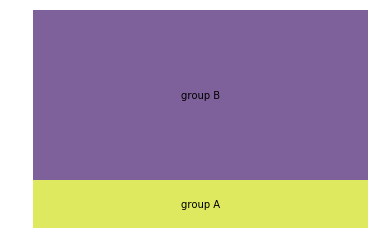

In [54]:
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
 
# If you have 2 lists
squarify.plot(sizes=[45786,162298], label=["group A", "group B", "group C", "group D"], alpha=.7 )
plt.axis('off')
plt.show()
 


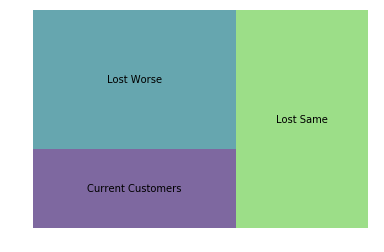

In [58]:
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
 
# If you have 2 lists
squarify.plot(sizes=[45786,80140, 40707+41451], label=["Current Customers", "Lost Worse", "Lost Same", "Lost Better"], alpha=.7 )
plt.axis('off')
plt.show()
 


In [57]:
40707+41451

82158

In [72]:
pd.crosstab(df.Outcome, df.Tier, margins=True)/208084*100

Tier,1,2,3,4,All
Outcome,,,,,
0,36.524192,17.235347,15.287576,8.949270,77.996386
1,11.658273,4.617366,3.728783,1.999193,22.003614
All,48.182465,21.852713,19.016359,10.948463,100.000000


In [81]:
pd.crosstab(df_0.Tier, df_0.Quote, margins=True)

Quote,Better,Same,Worse,All
Tier,,,,
1,34174,38909,2918,76001
2,6646,1165,28053,35864
3,627,632,30552,31811
4,4,1,18617,18622
All,41451,40707,80140,162298


### Computation of Opportunity Cost

In [37]:
opp = df.query('Outcome==0 and Quote=="Worse"')
opp_cost = sum(-opp.Competition_Margin / 100 * opp.Amount * opp.Term/12)
print("Opportunity cost = {}".format(opp_cost))

Opportunity cost = 192090476.43825024


In [38]:
opp.head()

,Tier,FICO,Term,Amount,Previous Rate,Competition rate,Outcome,Rate,Cost of Funds,Car Type_N,Car Type_R,Car Type_U,Partner Bin_1,Partner Bin_2,Partner Bin_3,Competition_Margin,Quote
45787,3,695,72,35000.0,0.0,6.25,0,7.49,1.8388,1,0,0,1,0,0,-1.24,Worse
45790,4,652,72,15415.0,0.0,6.25,0,8.99,1.8388,1,0,0,0,0,1,-2.74,Worse
45792,2,725,36,10000.0,0.0,4.95,0,5.79,1.8388,1,0,0,0,0,1,-0.84,Worse
45793,1,808,72,19000.0,0.0,6.25,0,6.59,1.8388,1,0,0,0,0,1,-0.34,Worse
45795,4,664,72,7500.0,0.0,6.25,0,8.99,1.8388,1,0,0,0,0,1,-2.74,Worse


In [42]:
(opp.Amount*opp.Term/12*(opp['Competition rate'] - opp['Cost of Funds'])/100).sum()/1000000

372.19831698634994

In [40]:
df_0 = df[df.Outcome==0]

In [68]:
x = [min(df_0['Competition rate'][i], df_0['Rate'][i]) for i in df_0.index]

In [69]:
(df_0.Amount*df_0.Term/12*(np.array(x) - df_0['Cost of Funds'])/100).sum()/1000000

749.4978354833332

In [16]:
cat = []
for a,b in zip(df.Outcome, df.Quote):
    if a==1 and b=='Worse':
        x = 'A'
    elif a==1 and b=='Same':
        x = 'B'
    elif a==0 and b=='Worse':
        x = 'B'
    elif a==1 and b=='Better':
        x = 'C'
    elif a==0 and b=='Same':
        x = 'C'
    else:
        x = 'D'
    cat.append(x)

In [17]:
df['Category'] = cat
df = df.drop('Approve Date', axis=1)

In [18]:
df.head()

,Tier,FICO,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin,Competition_Margin,Quote,Category
0,1,743,36,19100.00,0.0,N,4.95,1,4.85,1.8388,1,0.10,Better,C
1,1,752,60,36460.08,0.0,N,5.65,1,5.49,1.8388,1,0.16,Better,C
2,1,778,48,12000.00,0.0,U,5.85,1,5.85,1.8388,3,0.00,Same,B
3,2,724,60,19290.00,0.0,N,5.65,1,5.39,1.8388,3,0.26,Better,C
4,2,700,72,24461.12,0.0,N,6.25,1,6.99,1.8388,3,-0.74,Worse,A


In [19]:
df1 = df[df.Outcome==1]
df0 = df[df.Outcome==0]

In [20]:
X = pd.get_dummies(df.drop(['Outcome', 'Rate', 'Cost of Funds', 'Competition_Margin', 'Quote', 'Category'], axis=1))
y = df.Category
X.head()

,Tier,FICO,Term,Amount,Previous Rate,Competition rate,Car Type_N,Car Type_R,Car Type_U,Partner Bin_1,Partner Bin_2,Partner Bin_3
0,1,743,36,19100.00,0.0,4.95,1,0,0,1,0,0
1,1,752,60,36460.08,0.0,5.65,1,0,0,1,0,0
2,1,778,48,12000.00,0.0,5.85,0,0,1,0,0,1
3,2,724,60,19290.00,0.0,5.65,1,0,0,0,0,1
4,2,700,72,24461.12,0.0,6.25,1,0,0,0,0,1


### Preliminary Regression Model Analysis

In [21]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import pearsonr

import warnings
warnings.simplefilter(action='ignore')


In [22]:
def cls_logistic(X, y, reg, scaler=None, num_trials=20, 
                 C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000],
                 info=False):
    
    score_train, score_test, weights, intercepts = [], [], [], []
    for seed in range(num_trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, stratify=y, test_size=0.25, random_state=seed)
                        
        if scaler is not None:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
        acc_train, acc_test, m, b = [], [], [], []    
        for alpha in C:
            lr = LogisticRegression(C=alpha, penalty=reg, solver='liblinear', 
                                    multi_class='auto', max_iter=10000)
            lr.fit(X_train, y_train)
            acc_train.append(lr.score(X_train, y_train))
            acc_test.append(lr.score(X_test, y_test))
            m.append(lr.coef_)
            b.append(lr.intercept_)

        score_train.append(acc_train)
        score_test.append(acc_test)
        weights.append(m)
        intercepts.append(b)    
       
    max_score = np.amax(np.mean(score_test, axis=0))
    idx = np.argmax(np.mean(score_test, axis=0))
    max_C = C[idx]
    best_weights = np.mean(weights, axis=0)[idx][0]
    best_intercept = np.mean(intercepts, axis=0)[idx]
    indices = np.argsort(abs(best_weights))[::-1]
    top_features = list(X.columns[indices])
    
    if info:
        fig, ax = plt.subplots()
        ax.errorbar(C, np.mean(score_test, axis=0), 
                    yerr=np.std(score_test, axis=0), label="test accuracy")
        ax.errorbar(C, np.mean(score_train, axis=0), 
                    yerr=np.std(score_train, axis=0), label="training accuracy")
        ax.axvline(max_C, linestyle='--', color='green')
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("C")
        ax.set_xscale('log')
        ax.set_title("Logistic Regression Classifer ({})".format(reg))
        ax.grid(True)
        ax.legend()
    
    return {'ML Method':'Logistic ({})'.format(reg), 'Test Accuracy': max_score, 
            'Best Parameter':'C = {}'.format(max_C), 
            'Top Predictor Variable':'{}'.format(top_features[0]),
            'weights':best_weights, 'intercept':best_intercept,
            'Top Features':top_features}

In [25]:
cls_logistic(X,y, 'l2', MinMaxScaler(), 10)

{'ML Method': 'Logistic (l2)',
 'Test Accuracy': 0.6866056668332629,
 'Best Parameter': 'C = 100',
 'Top Predictor Variable': 'Amount',
 'weights': array([ 0.3903489 , -4.81198337,  1.38890392, -5.24031335,  4.09018472,
        -1.03492235, -0.925887  , -0.26657924,  1.12270131,  0.51398764,
        -0.82066167,  0.2369091 ]),
 'intercept': array([-0.06976493,  1.3545776 ,  0.7306071 , -3.33931515]),
 'Top Features': ['Amount',
  'FICO',
  'Previous Rate',
  'Term',
  'Car  Type_U',
  'Competition rate',
  'Car  Type_N',
  'Partner Bin_2',
  'Partner Bin_1',
  'Tier',
  'Car  Type_R',
  'Partner Bin_3']}

### Gradient Boosting Classifier

In [89]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()


for seedN in range(1,20,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []  
    test_accuracy = []
    depth_settings = range(1, 15) # try n_neighbors from 1 to 50

    for depth in depth_settings:   
        gbr = GradientBoostingClassifier(max_depth=depth, random_state=0, learning_rate=0.1)
        gbr.fit(X_train, y_train)
        training_accuracy.append(gbr.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(gbr.score(X_test, y_test))   # record generalization accuracy
    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings, lahat_training.mean(axis=1),
              yerr=lahat_training.std(axis=1), label="training accuracy")
plt.errorbar(depth_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.std(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
best_nestimator=np.argmax(lahat_test.mean(axis=1))+1
print("Highest Average Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best max_depth = %d" %best_nestimator )

In [85]:
# from sklearn.ensemble import GradientBoostingClassifier

# # gbc = GradientBoostingClassifier(random_state=0, max_depth=1)
# # gbrt.fit(X_train, y_train)
# # plot_feature_importances_cancer(forest)

In [76]:


from sklearn.model_selection import train_test_split
import pandas as pd

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()



GradientBoostingClassifier(random_state=0)
for seedN in range(1,20,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []  
    test_accuracy = []
    depth_settings = range(1, 15) # try n_neighbors from 1 to 50

    for depth in depth_settings:   
        gbr = GradientBoostingRegressor(max_depth=depth, random_state=0, learning_rate=0.1)
        gbr.fit(X_train, y_train)
        training_accuracy.append(gbr.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(gbr.score(X_test, y_test))   # record generalization accuracy
    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy

KeyboardInterrupt: 

#### Model and Training Test Accuracy

Highest Average Test Set Achieved = 0.999732
Best max_depth = 8


C:\Users\Rivero\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


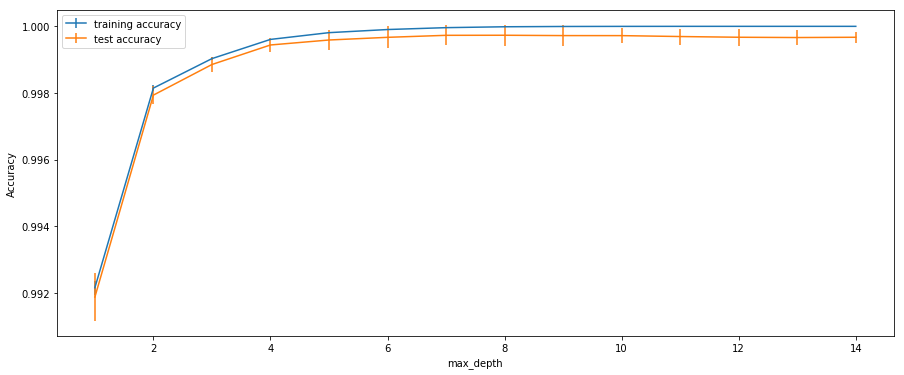

In [104]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings, lahat_training.mean(axis=1),
              yerr=lahat_training.std(axis=1), label="training accuracy")
plt.errorbar(depth_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.std(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
best_nestimator=np.argmax(lahat_test.mean(axis=1))+1
print("Highest Average Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best max_depth = %d" %best_nestimator )

In [105]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1208)
gbr = GradientBoostingRegressor(max_depth=8, random_state=0, learning_rate=0.1)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [108]:
gbr.score(X_test, y_test)

0.9987530659857154

In [109]:
gbr.score(X,y)

0.9996763144781415

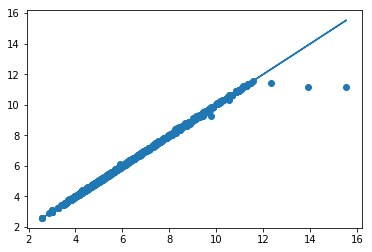

In [113]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr.predict(X_test))
ax.plot(y_test, y_test)

In [114]:
df_0 = df[df.Outcome==0]

In [117]:
X_test.columns

Index(['Tier', 'FICO', 'Term', 'Amount', 'Previous Rate', 'Competition rate',
       'Cost of Funds', 'Partner Bin', 'Proft_Margin', 'Car  Type_N',
       'Car  Type_R', 'Car  Type_U'],
      dtype='object')

In [118]:
df_0.columns

Index(['Tier', 'FICO', 'Term', 'Amount', 'Previous Rate', 'Car  Type',
       'Competition rate', 'Outcome', 'Rate', 'Cost of Funds', 'Partner Bin',
       'Proft_Margin', 'Competition_Margin', 'Quote'],
      dtype='object')

In [119]:
X_0 = pd.get_dummies(df_0.drop(['Outcome', 'Rate', 'Competition_Margin', 'Quote'], axis=1))

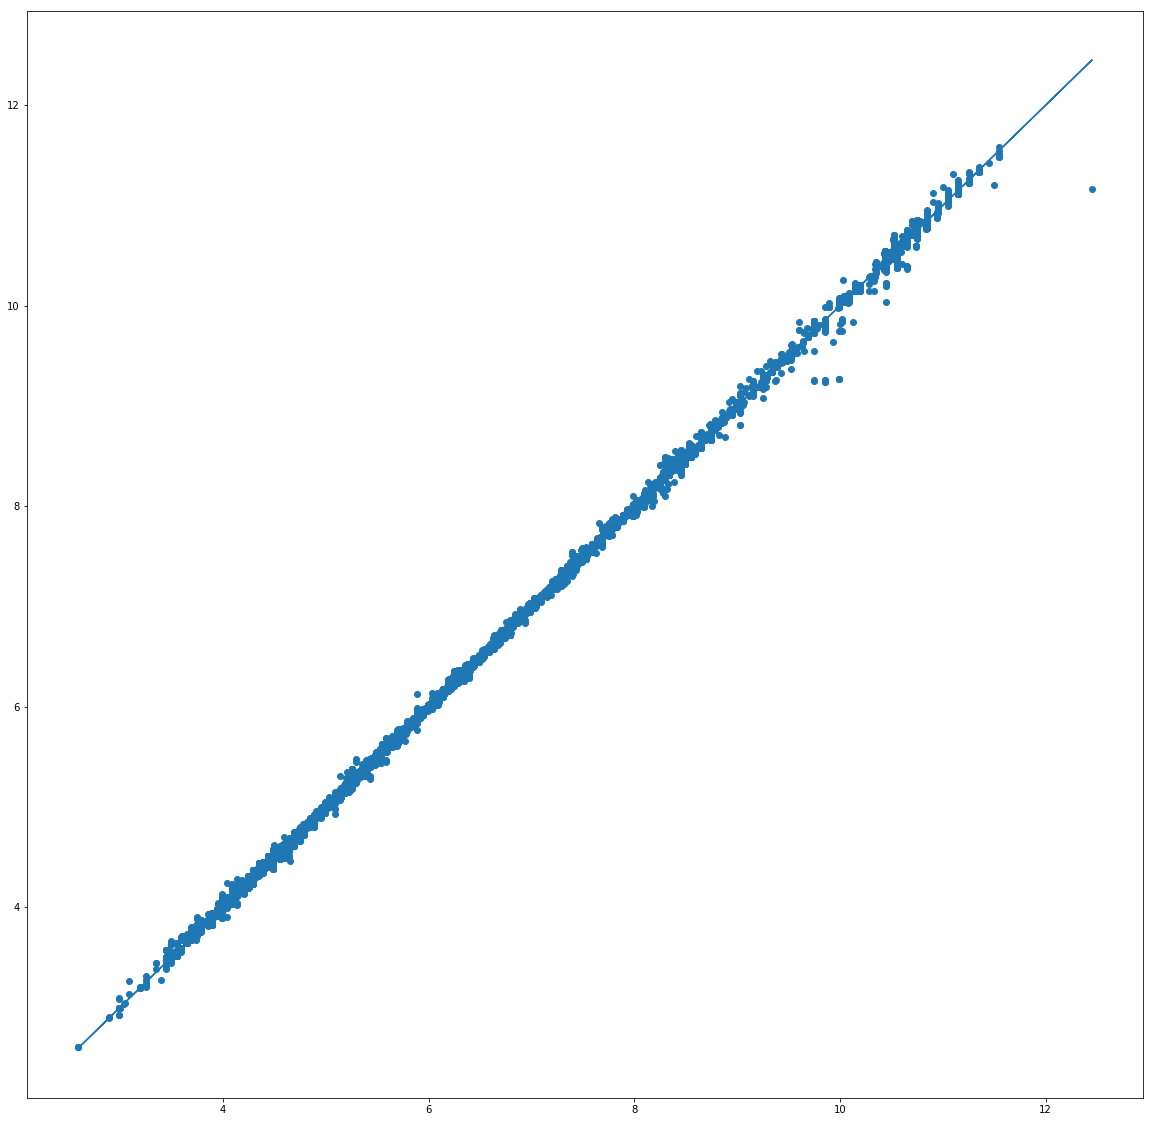

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(df_0.Rate, gbr.predict(X_0))
ax.plot(df_0.Rate, df_0.Rate)

In [123]:
X_0.shape

(162298, 12)

In [128]:
np.mean(gbr.predict(X_0)-df_0.Rate <= 0)

0.5355765320583125

In [142]:
a = list(df_0.Rate)
b = list(df_0['Competition rate'])
c = pd.Series([min(a[i], b[i]) for i in range(len(a))])
np.mean(gbr.predict(X_0)- c <= 0)

0.26991090463221973

In [5]:
# import dill
# dill.dump_session('lab_before_tree.db')


In [4]:
import dill
dill.load_session('lab_before_tree.db')


In [7]:
df_1.groupby('Quote').size()

Quote
Better    13831
Same      13029
Worse     18927
dtype: int64

In [8]:
df_1

,Tier,FICO,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin,Proft_Margin,Competition_Margin,Quote
0,1,743,36,19100.00,0.00,N,4.95,1,4.85,1.8388,1,3.0112,0.10,Better
1,1,752,60,36460.08,0.00,N,5.65,1,5.49,1.8388,1,3.6512,0.16,Better
2,1,778,48,12000.00,0.00,U,5.85,1,5.85,1.8388,3,4.0112,0.00,Same
3,2,724,60,19290.00,0.00,N,5.65,1,5.39,1.8388,3,3.5512,0.26,Better
4,2,700,72,24461.12,0.00,N,6.25,1,6.99,1.8388,3,5.1512,-0.74,Worse
5,1,756,66,12251.00,0.00,U,6.45,1,6.49,1.8388,1,4.6512,-0.04,Worse
6,4,658,60,18888.75,0.00,U,5.85,1,7.99,1.8388,1,6.1512,-2.14,Worse
7,1,766,72,10555.49,0.00,U,6.45,1,6.69,1.8388,1,4.8512,-0.24,Worse
8,1,779,72,20011.59,0.00,N,6.25,1,6.59,1.8388,1,4.7512,-0.34,Worse
9,2,701,60,16510.00,0.00,U,5.85,1,6.19,1.8388,1,4.3512,-0.34,Worse


In [15]:
df_1['Partner Bin'] = df_1['Partner Bin'].astype('category')
XX1 = df_1.drop(['Competition rate', 'Outcome', 'Cost of Funds', 'Proft_Margin', 'Quote'], axis=1)

In [16]:
y1 = df_1.Quote

In [17]:
pd.get_dummies(df_1)

,Tier,FICO,Term,Amount,Previous Rate,Competition rate,Outcome,Rate,Cost of Funds,Proft_Margin,Competition_Margin,Car Type_N,Car Type_R,Car Type_U,Partner Bin_1,Partner Bin_2,Partner Bin_3,Quote_Better,Quote_Same,Quote_Worse
0,1,743,36,19100.00,0.00,4.95,1,4.85,1.8388,3.0112,0.10,1,0,0,1,0,0,1,0,0
1,1,752,60,36460.08,0.00,5.65,1,5.49,1.8388,3.6512,0.16,1,0,0,1,0,0,1,0,0
2,1,778,48,12000.00,0.00,5.85,1,5.85,1.8388,4.0112,0.00,0,0,1,0,0,1,0,1,0
3,2,724,60,19290.00,0.00,5.65,1,5.39,1.8388,3.5512,0.26,1,0,0,0,0,1,1,0,0
4,2,700,72,24461.12,0.00,6.25,1,6.99,1.8388,5.1512,-0.74,1,0,0,0,0,1,0,0,1
5,1,756,66,12251.00,0.00,6.45,1,6.49,1.8388,4.6512,-0.04,0,0,1,1,0,0,0,0,1
6,4,658,60,18888.75,0.00,5.85,1,7.99,1.8388,6.1512,-2.14,0,0,1,1,0,0,0,0,1
7,1,766,72,10555.49,0.00,6.45,1,6.69,1.8388,4.8512,-0.24,0,0,1,1,0,0,0,0,1
8,1,779,72,20011.59,0.00,6.25,1,6.59,1.8388,4.7512,-0.34,1,0,0,1,0,0,0,0,1
9,2,701,60,16510.00,0.00,5.85,1,6.19,1.8388,4.3512,-0.34,0,0,1,1,0,0,0,0,1


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()

for seedN in range(1,20,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []  
    test_accuracy = []
    depth_settings = range(1, 15) # try n_neighbors from 1 to 50

    for depth in depth_settings:   
        gbr = GradientBoostingRegressor(max_depth=depth, random_state=0, learning_rate=0.1)
        gbr.fit(X_train, y_train)
        training_accuracy.append(gbr.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(gbr.score(X_test, y_test))   # record generalization accuracy
    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy